### **This notebook is used to generate segmentation results for input size of 64 X 64**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install nilearn


     |████████████████████████████████| 3.1MB 8.3MB/s 


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
import keras
from keras.models import Model, load_model
from keras.layers import Input ,BatchNormalization , Activation 
from keras.layers.convolutional import Conv2D, UpSampling2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import optimizers 
from sklearn.model_selection import train_test_split
import os
import nibabel as nib
import cv2 as cv
import matplotlib.pyplot as plt
from keras import backend as K
import glob
import skimage.io as io
import skimage.color as color
import random as r
import math
from nilearn import plotting
import pickle
import skimage.transform as skTrans
from nilearn import image
from nilearn.image import resample_img
import nibabel.processing
import warnings

/usr/local/lib/python3.7/dist-packages/nilearn/datasets/__init__.py:90: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


In [ ]:
for dirname, _, filenames in os.walk('/content/drive/MyDrive/MRI Data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
"""
rescale_Nii(nifti_file):
This function takes a .nii files as an input and rescales it according to the 
values of voxel_dims by creating a new affine transform. The new affine transform
is used in resample_img() function from nibable library which will transform the images
accordinly inputs for resample_img() are tagert image, target affine transform and target shape

Input:
nifti_file: A .nii file which we want to rescale

Output:
rescaled .nii file with dimensions as defined in target_shape
"""


def rescale_Nii(nifti_file):
    warnings.filterwarnings("ignore")
    img=nifti_file
    voxel_dims=[3.8, 3.8,1]
    #voxel_dims=[1.60, 1.60,1]
    

    # downl sample to 128*128*155
    target_shape=(64,64,130)
    #target_shape=(128,128,155)
    # Initialize target_affine
    target_affine = img.affine.copy()
    # Calculate the translation part of the affine
    spatial_dimensions = (img.header['dim'] * img.header['pixdim'])[1:4]
    
    # Calculate the translation affine as a proportion of the real world
    # spatial dimensions
    image_center_as_prop = img.affine[0:3,3] / spatial_dimensions
    
    # Calculate the equivalent center coordinates in the target image
    dimensions_of_target_image = (np.array(voxel_dims) * np.array(target_shape))
    target_center_coords =  dimensions_of_target_image * image_center_as_prop
    # Decompose the image affine to allow scaling
    u,s,v = np.linalg.svd(target_affine[:3,:3],full_matrices=False)
    
    # Rescale the image to the appropriate voxel dimensions
    s = voxel_dims
    
    # Reconstruct the affine
    target_affine[:3,:3] = u @ np.diag(s) @ v

    # Set the translation component of the affine computed from the input
    target_affine[:3,3] = target_center_coords 
  

    #target_affine = rescale_affine(target_affine,voxel_dims,target_center_coords)
    resampled_img = resample_img(img, target_affine=target_affine,target_shape=target_shape)
    resampled_img.header.set_zooms((np.absolute(voxel_dims)))
    return resampled_img
   

In [ ]:
"""
Data_Concatenate(Input_Data):
Converts a numpy array with fused images ( eg: (20, 130, 128, 128, 2)) 
into an array with two partitions(eg: (2, 2600, 128, 128, 1)).

Input:
Input_Data= Array which contains information of all the modalities

Output:
Fused array which will used for making the training and testing split

"""
def Data_Concatenate(Input_Data):
    counter=0
    Output= []
    for i in range(5):
        print('$')
        c=0
        counter=0
        for ii in range(len(Input_Data)):

            if (counter < len(Input_Data)-1):
                a= Input_Data[counter][:,:,:,i]
                #print('a={}'.format(a.shape))
                b= Input_Data[counter+1][:,:,:,i]
                #print('b={}'.format(b.shape))
                if (counter==0):
                    c= np.concatenate((a, b), axis=0)
                    print('c1={}'.format(c.shape))
                    counter= counter+2
                else:
                    c1= np.concatenate((a, b), axis=0)
                    c= np.concatenate((c, c1), axis=0)
                    print('c2={}'.format(c.shape))
                    counter= counter+2
            
            if (counter == len(Input_Data)-1):
              a= Input_Data[counter][:,:,:,i]
              c= np.concatenate((c, a), axis=0)
              print('c2={}'.format(c.shape))
              counter=counter+2


        c= c[:,:,:,np.newaxis]
        Output.append(c)
    return Output

### **Data Preprocessing**

In [ ]:
Path= '/content/drive/MyDrive/MRI Data/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData'
p=os.listdir(Path)
Input_Data= []
def Data_Preprocessing(modalities_dir):
    all_modalities = []    
    for modality in modalities_dir:   
        nifti_file   = nib.load(modality)
        nifti_file= rescale_Nii(nifti_file)
        brain_numpy  = np.asarray(nifti_file.dataobj)    
        all_modalities.append(brain_numpy)
    brain_affine   = nifti_file.affine
    all_modalities = np.array(all_modalities)
    all_modalities = np.rint(all_modalities).astype(np.int16)
    all_modalities = all_modalities[:, :, :, :]
    all_modalities = np.transpose(all_modalities)
    return all_modalities

for i in p[:369]:
  
    brain_dir = os.path.normpath(Path+'/'+i)
    flair     = glob.glob(os.path.join(brain_dir, '*_flair*.nii'))
    t1        = glob.glob(os.path.join(brain_dir, '*_t1*.nii'))
    t1ce      = glob.glob(os.path.join(brain_dir, '*_t1ce*.nii'))
    t2        = glob.glob(os.path.join(brain_dir, '*_t2*.nii'))
    gt        = glob.glob( os.path.join(brain_dir, '*_seg*.nii'))
    
    modalities_dir = [flair[0], t1[0], t1ce[0], t2[0], gt[0]]
    P_Data = Data_Preprocessing(modalities_dir)
    Input_Data.append(P_Data)


In [ ]:
# save the input data for future use 
with open("/content/drive/MyDrive/MRI Data/TrainingData NumPy/1_369.txt", "wb") as fp:   # pickling
   pickle.dump(Input_Data,fp)

In [ ]:
with open("/content/drive/MyDrive/MRI Data/TrainingData NumPy/1_369_(64*64*130).txt", "rb") as fp:   # un-pickling
  Input_Data= pickle.load(fp)

In [ ]:
InData= Data_Concatenate(Input_Data)

$
c1=(260, 64, 64)
c2=(520, 64, 64)
c2=(780, 64, 64)
c2=(1040, 64, 64)
c2=(1300, 64, 64)
c2=(1560, 64, 64)
c2=(1820, 64, 64)
c2=(2080, 64, 64)
c2=(2340, 64, 64)
c2=(2600, 64, 64)
c2=(2860, 64, 64)
c2=(3120, 64, 64)
c2=(3380, 64, 64)
c2=(3640, 64, 64)
c2=(3900, 64, 64)
c2=(4160, 64, 64)
c2=(4420, 64, 64)
c2=(4680, 64, 64)
c2=(4940, 64, 64)
c2=(5200, 64, 64)
c2=(5460, 64, 64)
c2=(5720, 64, 64)
c2=(5980, 64, 64)
c2=(6240, 64, 64)
c2=(6500, 64, 64)
c2=(6760, 64, 64)
c2=(7020, 64, 64)
c2=(7280, 64, 64)
c2=(7540, 64, 64)
c2=(7800, 64, 64)
c2=(8060, 64, 64)
c2=(8320, 64, 64)
c2=(8580, 64, 64)
c2=(8840, 64, 64)
c2=(9100, 64, 64)
c2=(9360, 64, 64)
c2=(9620, 64, 64)
c2=(9880, 64, 64)
c2=(10140, 64, 64)
c2=(10400, 64, 64)
c2=(10660, 64, 64)
c2=(10920, 64, 64)
c2=(11180, 64, 64)
c2=(11440, 64, 64)
c2=(11700, 64, 64)
c2=(11960, 64, 64)
c2=(12220, 64, 64)
c2=(12480, 64, 64)
c2=(12740, 64, 64)
c2=(13000, 64, 64)
c2=(13260, 64, 64)
c2=(13520, 64, 64)
c2=(13780, 64, 64)
c2=(14040, 64, 64)
c2=(14300, 64

In [ ]:
AIO= concatenate(InData, axis=3)

In [ ]:
AIO=np.array(AIO,dtype='float32')
TR=np.array(AIO[:,:,:,1],dtype='float32')
TRL=np.array(AIO[:,:,:,4],dtype='float32')#segmentation
X_train , X_test, Y_train, Y_test = train_test_split(TR, TRL, test_size=0.15, random_state=32)

### **Model Training**

In [ ]:
def Convolution(input_tensor,filters):
    
    x = Conv2D(filters=filters,kernel_size=(3, 3),padding = 'same',strides=(1, 1))(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x) 
    return x

def model(input_shape):
    
    inputs = Input((input_shape))
    
    conv_1 = Convolution(inputs,32)
    maxp_1 = MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'same') (conv_1)
    
    conv_2 = Convolution(maxp_1,64)
    maxp_2 = MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'same') (conv_2)
    
    conv_3 = Convolution(maxp_2,128)
    maxp_3 = MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'same') (conv_3)
    
    conv_4 = Convolution(maxp_3,256)
    maxp_4 = MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'same') (conv_4)
    
    conv_5 = Convolution(maxp_4,512)
    upsample_6 = UpSampling2D((2, 2)) (conv_5)
    
    conv_6 = Convolution(upsample_6,256)
    upsample_7 = UpSampling2D((2, 2)) (conv_6)
    
    upsample_7 = concatenate([upsample_7, conv_3])
    
    conv_7 = Convolution(upsample_7,128)
    upsample_8 = UpSampling2D((2, 2)) (conv_7)
    
    conv_8 = Convolution(upsample_8,64)
    upsample_9 = UpSampling2D((2, 2)) (conv_8)
    
    upsample_9 = concatenate([upsample_9, conv_1])
    
    conv_9 = Convolution(upsample_9,32)
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (conv_9)
    
    model = Model(inputs=[inputs], outputs=[outputs]) 
    
    return model

In [ ]:
# Loding the Light weighted CNN
model = model(input_shape = (64,64,1))
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 64, 64, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 64, 64, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
# Computing Dice_Coefficient
def dice_coef(y_true, y_pred, smooth=1.0):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2 * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)/100

# Computing Precision 
def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

# Computing Sensitivity      
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

# Computing Specificity
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [ ]:
# Compiling the model 
Adam=optimizers.Adam(lr=0.001)
model.compile(optimizer=Adam, loss='binary_crossentropy', metrics=['accuracy',dice_coef,precision,sensitivity,specificity])

In [ ]:
# Fitting the model over the data
history = model.fit(X_train,Y_train,batch_size=32,epochs=40,validation_split=0.20,verbose=1,initial_epoch=0)

Epoch 1/40
1020/1020 [==============================] - 16s 15ms/step - loss: -0.0788 - accuracy: 0.9829 - dice_coef: 0.5513 - precision: 0.6760 - sensitivity: 0.8074 - specificity: 0.9937 - val_loss: 0.2372 - val_accuracy: 0.8930 - val_dice_coef: 0.1907 - val_precision: 0.1048 - val_sensitivity: 0.8529 - val_specificity: 0.9022
Epoch 2/40
1020/1020 [==============================] - 14s 14ms/step - loss: -0.1014 - accuracy: 0.9843 - dice_coef: 0.6009 - precision: 0.7103 - sensitivity: 0.8405 - specificity: 0.9947 - val_loss: 1.0639 - val_accuracy: 0.7520 - val_dice_coef: 0.0896 - val_precision: 0.0404 - val_sensitivity: 0.7460 - val_specificity: 0.7595
Epoch 3/40
1020/1020 [==============================] - 14s 14ms/step - loss: -0.1185 - accuracy: 0.9850 - dice_coef: 0.6341 - precision: 0.7353 - sensitivity: 0.8634 - specificity: 0.9952 - val_loss: 1.3855 - val_accuracy: 0.7438 - val_dice_coef: 0.0977 - val_precision: 0.0435 - val_sensitivity: 0.8387 - val_specificity: 0.7510
Epoch 4

In [ ]:
# Evaluating the model on the training and testing data 
model.evaluate(x=X_test, y=Y_test, batch_size=32, verbose=1, sample_weight=None, steps=None)

In [ ]:
def Accuracy_Graph(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    #plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.subplots_adjust(top=1.00, bottom=0.0, left=0.0, right=0.95, hspace=0.25,
                        wspace=0.35)
    plt.show()
    
# Dice Similarity Coefficient vs Epoch
def Dice_coefficient_Graph(history):

    plt.plot(history.history['dice_coef'])
    plt.plot(history.history['val_dice_coef'])
    #plt.title('Dice_Coefficient')
    plt.ylabel('Dice_Coefficient')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.subplots_adjust(top=1.00, bottom=0.0, left=0.0, right=0.95, hspace=0.25,
                        wspace=0.35)
    plt.show()
# Loss vs Epoch
def Loss_Graph(history):

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    #plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.subplots_adjust(top=1.00, bottom=0.0, left=0.0, right=0.95, hspace=0.25,
                        wspace=0.35)
    plt.show()

In [ ]:
# Plotting the Graphs of Accuracy, Dice_coefficient, Loss at each epoch on Training and Testing data
Accuracy_Graph(history)
Dice_coefficient_Graph(history)
Loss_Graph(history)

In [ ]:
# save model for future use 
model.save('/content/drive/MyDrive/MRI Data/TrainingData NumPy/64*64.h5')

### **Predicting Tumor**

In [ ]:
#load weights
model.load_weights('/content/drive/MyDrive/MRI Data/TrainingData NumPy/64*64.h5')

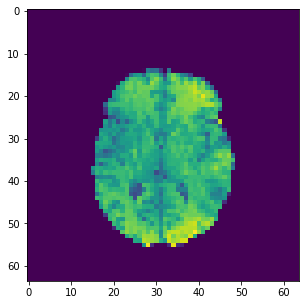

In [ ]:
fig = plt.figure(figsize=(5,5))
immmg = TR[205,:,:]
imgplot = plt.imshow(immmg)
plt.show()

In [ ]:
pref_Tumor = model.predict(TR)


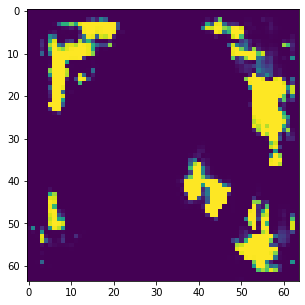

In [ ]:
fig = plt.figure(figsize=(5,5))
immmg = pref_Tumor[205,:,:,0]
imgplot = plt.imshow(immmg)
plt.show()